In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import punkt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from src.functions import get_sents, display_topics
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Get the collection of n(=1)-sentence snippets with the word 'love'
love_snippets = pd.read_pickle('./data/processed/love_snippets')

From results EDA I found that talk ID=132 and 2382 were 'outliers' after dimension reduction was performed when using CountVectorizer(binary=False).  These two talks were songs that mentioned love a lot.  By deleting them I'm trying to capture orthogonal variance in topics modeling to not be dominated by these 2 talks.

In [3]:
love_snippets.loc[[132, 2382]]

,transcript,url,n_love_sents,love
132,I’d like to dedicate this one to all the women...,https://www.ted.com/talks/vusi_mahlasela_sings...,12.0,"♫ ♫ Should I now stop singing of love, ♫ ♫ now..."
2382,(Sings) Water Boy(Guitar strum)where are you h...,https://www.ted.com/talks/rhiannon_giddens_3_s...,15.0,So I wrote a song based on some of those narra...


I'll uncomment this when I want those song talks eliminated.

In [4]:
love_snippets.drop(labels=[132, 2382],inplace=True)

In [5]:
# Topic modeling
# Vectorize
cv1 = CountVectorizer(stop_words='english',binary=False)
cv_doc_word = cv1.fit_transform(love_snippets.love)
# Dimension Reduction
cv_lsa=[]
cv_doc_topic=[]
for i in range(2,6):
    cv_lsa.append(TruncatedSVD(i))
    cv_doc_topic.append(cv_lsa[i-2].fit_transform(cv_doc_word))
    print(int(i),'topics variance ratios:',cv_lsa[i-2].explained_variance_ratio_)

2 topics variance ratios: [0.35450067 0.03588727]
3 topics variance ratios: [0.35450067 0.03588728 0.02086246]
4 topics variance ratios: [0.35450067 0.03588728 0.02086142 0.01752554]
5 topics variance ratios: [0.35450067 0.03588727 0.02086135 0.01752582 0.01359874]


In [6]:
display_topics(cv_lsa[0], cv1.get_feature_names(), 14)


Topic  0
love, romantic, people, just, like, loved, think, know, want, ve, laughter, fall, really, brain

Topic  1
la, thank, li, janitor, want, boy, oh, lovewith, know, gave, bound, boyis, music, making


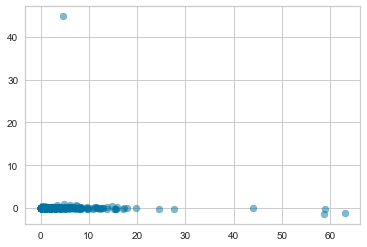

In [7]:
plt.scatter(cv_doc_topic[0][:,0],cv_doc_topic[0][:,1], alpha = 0.5);
# plt.axis([0, 60, -30, 10])

Investigating the interesting result above seemed  to show that the points in the upper right had longer snippets.  So, I decided to see if there was a relationship with the number of sentences with love in it:

Matplotlib colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

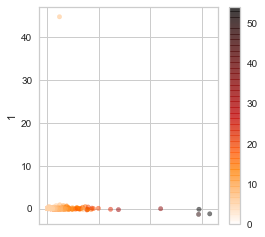

In [8]:
df=pd.DataFrame(cv_doc_topic[0])
df.plot.scatter(x=0,y=1,figsize=(4,4), alpha=0.5,\
               c=love_snippets.n_love_sents+3, cmap=plt.get_cmap('gist_heat_r'),vmin=0);

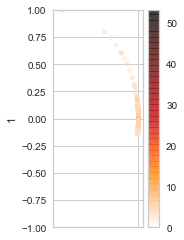

In [9]:
df = pd.DataFrame(normalize(cv_doc_topic[0]))
df.plot.scatter(x=0,y=1,figsize=(2,4), alpha=0.5,\
               c=love_snippets.n_love_sents+2, cmap=plt.get_cmap('gist_heat_r'),vmin=0)
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

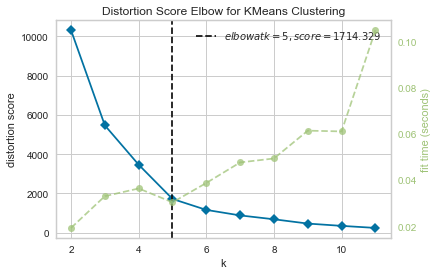

In [10]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(cv_doc_topic[0])        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

In [11]:
visualizer.elbow_value_

5

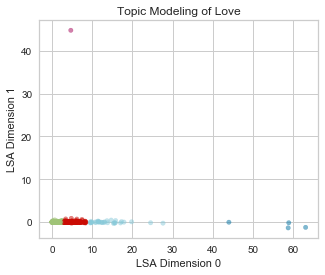

In [12]:
df=pd.DataFrame(cv_doc_topic[0],columns=['LSA Dimension 0','LSA Dimension 1'])
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=None,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x='LSA Dimension 0',y='LSA Dimension 1',\
                figsize=(5,4), c=col, alpha = 0.5,title='Topic Modeling of Love');
# plt.axis([-1,1.05,-1,1]);

In [13]:
for i,center in enumerate(km.cluster_centers_):
    print(cmap[i],center)

r [ 4.35340085 -0.01363158]
g [ 1.12562242 -0.00468251]
b [56.17904295 -0.70959931]
c [13.91757792 -0.03443014]
m [ 4.67868909 44.78070875]


Getting the matrix of euclidean distances from the cluster centers: (used to work that out)

In [14]:
pd.DataFrame(pairwise_distances(km.cluster_centers_,cv_doc_topic[0]).T).head()

,0,1,2,3,4
0,2.232782,0.995477,54.062578,11.796877,44.886484
1,3.226871,0.018389,55.056781,12.791040,44.944348
2,3.347734,0.120532,55.177971,12.911912,44.923340
3,3.174534,0.056683,55.004431,12.738698,44.941268
4,9.331580,12.557796,42.511245,0.409253,45.383638


Show the snippets from the 4 (euclidean distance) closest documents:

In [15]:
doc_topic = cv_doc_topic[0]
euclidean_distances_to_centers=pd.DataFrame(pairwise_distances(km.cluster_centers_,doc_topic).T)
for i,center in enumerate(km.cluster_centers_):
    n_closest=euclidean_distances_to_centers[i].nsmallest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,cs in n_closest.iteritems():
#         print(j,cs)
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 4.35340085 -0.01363158] color= r
816 : [4.33396354 0.00806383] Can you imagine our country embracing young black men, seeing them as part of our future, giving them that kind of openness, that kind of grace we give to people we love? When we see something, we have to have the courage to say something, even to the people we love. And you know, we love Grandma and we love Uncle Joe. We've got to take  our lovely darlings, our future, and we've got to tell them we have  an amazing country with incredible ideals, we have worked incredibly hard, and we have made some progress, but we are not done.
1000 : [4.36332136 0.01817658] And that is why, although my daughter is an athlete, she's also a huge nerd, which I love. But she knows there's someone called the Mother of Dragons, and she calls herself that and she loves it. She loves Groot. She's played by Zoe Saldana, and she is strong and smart and fast and fights like a ninja, and she is played by a beautiful black wom

I'll now project the doc_topic values onto the unit circle, sphere, hypersphere I.  If I don't re-cluster yet, I'm looking at the clustering results from above:

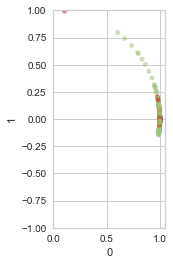

In [16]:
df = pd.DataFrame(normalize(doc_topic))
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

This next cell identifies the documents closest to the cluster centers using cosine similarity.

In [17]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=doc_topic).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 4.35340085 -0.01363158] color= r
1135 : [ 6.98244182 -0.02181228] From our love of Colorado to our love of sushi, there wasn't much we didn't agree on. We also discovered that we share a deep love of this country and feel a responsibility to be politically active. CQ: I may hate camping, but I love politics. (Laughter)Seeing Lauran's sons at the march and holding signs took it to a new level for me, and not in a good way, because I know these boys, I love these boys, and I didn't feel they were old enough to understand what the march stood for. "But we love them. Love you.
652 : [ 4.04717425 -0.01262042] The second aspect is love. And I just love this guy. I've been in love with this guy since I was a kid. And I wanted this guy to be involved in my crazy project, and he was kind enough to lend his image to the character of Eugène Spaak, who is a cosmologist and artist who seeks relation in between time, space, love, music and women.
672 : [ 1.05279404 -0.0033263 

Now clustering on the 

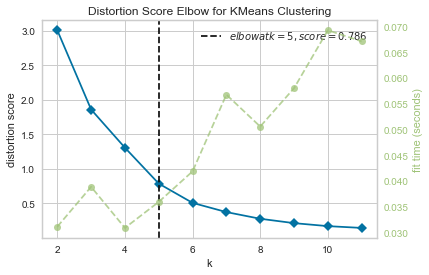

In [18]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)        # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

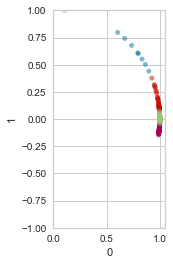

In [19]:
df = pd.DataFrame(normalize(doc_topic))
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

In [20]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [0.98537758 0.15113173] color= r
957 : [0.98871076 0.14983666] They were simply so good at making what they loved doing, that they wouldn't change.
847 : [0.98936144 0.1454783 ] If you are a parent, you know that kids love to keep making circles. The boy on the branch, he loves the tree so he is eating the tree.
179 : [0.98981386 0.14236754] Love it. I mean, I love the fact that I can go in anywhere and pick out what I want — the shoes I want, the skirts I want — and I'm hoping to try to bring these over here and make them accessible to a lot of people.
334 : [0.98564097 0.16885463] And if people feel used, worthless and ashamed, because something horrible has happened to them, then they retreat, and they fall into social isolation, and they do not dare to tell this evil to other people or to their loved ones, because they do not want to burden them.


Cluster centered at: [ 0.99981777 -0.00892621] color= g
594 : [ 0.99996046 -0.0088923 ] Overnight, my inbox morphe

# The 3-topic Result

In [21]:
display_topics(cv_lsa[1], cv1.get_feature_names(), 14)


Topic  0
love, romantic, people, just, like, loved, think, know, want, ve, laughter, fall, really, brain

Topic  1
la, thank, li, janitor, want, boy, oh, lovewith, know, gave, bound, boyis, music, making

Topic  2
romantic, brain, somebody, fall, attachment, sex, madly, drive, dopamine, love, systems, mating, person, deep


In [22]:
cv_doc_topic[1]

array([[ 2.12070103, -0.03278425, -0.7866032 ],
       [ 1.12654311, -0.02304485, -0.39288059],
       [ 1.00573525,  0.00779111,  0.06145928],
       ...,
       [ 0.97426408, -0.01196234,  0.05676218],
       [ 1.16277211, -0.02748069, -0.36371757],
       [ 1.98235358, -0.0287015 , -0.06728337]])

In [23]:
from mpl_toolkits.mplot3d import Axes3D

In [24]:
# Use this to visualize the un-projected doc-topic space:
# df = pd.DataFrame(cv_doc_topic[1])
# Use this to visualize the projected doc-topic space:
df = pd.DataFrame(normalize(cv_doc_topic[1]))

Helpful in getting started with 3D plotting:
* https://pythonprogramming.net/3d-graphing-pandas-matplotlib/
* https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py
* https://stackoverflow.com/questions/47311632/jupyter-how-to-rotate-3d-graph

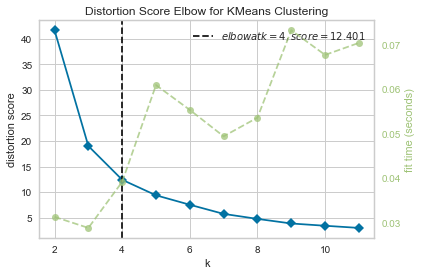

In [25]:
%matplotlib inline
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)                     # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [26]:
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


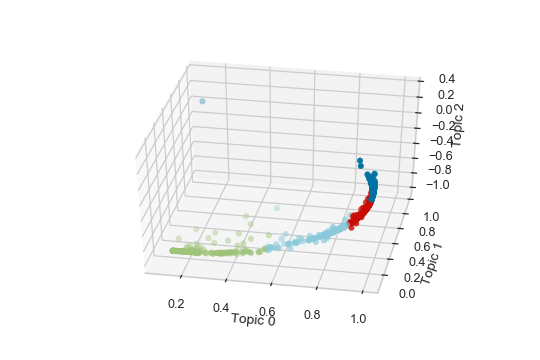

In [30]:
%matplotlib notebook
fig = plt.figure() #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2');

So, what do the clusters mean?

In [31]:
doc_topic = cv_doc_topic[1]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.96937496 -0.00469679 -0.22680871] color= r
111 : [ 0.97284028 -0.0110675  -0.23121267] I always live in the present — I love the present. That's Arthur Leipzig's original photograph I loved. I love being at TED.
1131 : [ 0.97478579 -0.01272451 -0.22277962] And then on top of that you have a steady stream of visitors and volunteers coming in, showering you in the love and affection you're craving and then leaving again, evoking all of those feelings of abandonment, and proving again and again that you are not worthy of being loved. She was suffering terrible neglect, and she yearned desperately for the warmth and love of her mother.
606 : [ 0.97477743 -0.01450056 -0.22270765] Tell the Iranians we from Israel love you too. " ")("I love that blue. I love that star. I love that flag. ") This one is really moving for me because it's the story of a girl who has been raised in Iran to walk on an Israeli flag to enter her school every morning, and now that she sees the